# NEXT-CLICK PREDICTION SYSTEM

## Team Members:
- Jharana Adhikari (C0927442)
- Raemil Corniel (C0922799)
- Uma Maheshwari Balaji (C0928443)
- Yasaswin Palukuri (C0928450)


In this project, we build a **Next-Click Prediction System** for *Fashion Campus*, an Indonesian fashion e-commerce platform targeting young urban consumers. The goal is to predict the next product a user is likely to click based on their browsing behavior.

### Datasets Used:
1. **Clickstream Data** (`click_customer.csv`) – 100K sampled records of customer browsing behavior (from original 12.8M) to ensure faster model training.
2. **Product Metadata** (`product.csv`) – 44K product entries with descriptions and categories.
3. **Customer Demographics** (`customer.csv`) – 100K customer profiles.
4. **Transaction Data** (`transaction.csv`) – 850K completed purchase records.

### Techniques & Methodologies:
- **Feature Engineering**: Time-based features, session click stats, metadata parsing.
- **Click Sequences**: Extracted per session for modeling.
- **Product Embeddings**: Generated using Word2Vec for semantic similarity.
- **Visualization**: Used t-SNE and heatmaps to understand embedding space and click patterns.
- **Next-Click Modeling**:
  - **Markov Chain** for sequential probabilistic transitions.
  - **GRU** (Gated Recurrent Unit) for deep sequence modeling of user behavior.
- **Evaluation**: Confusion matrix, classification report, and **Top-K Accuracy**.
- **User Interface**: Command-line interface (CLI) for user interaction and prediction demo.

###  Model Performance

| Model         | Top-1 Accuracy | Top-3 Accuracy |
|---------------|----------------|----------------|
| Markov Chain  | 88.68%         | 90.07%         |
| GRU           | 87.16%         | 88.51%         |

This project combines classic probabilistic modeling, deep learning, and embedding-based recommendations to build a scalable and interactive next-click prediction engine.



## 1. Installing Necessary Packages

In [7]:
# !pip install gensim==4.3.2
# !pip install seaborn
# !pip install --upgrade --force-reinstall tensorflow==2.15.0
# !pip install --upgrade --force-reinstall gensim==4.3.2 scipy==1.10.1

## 2. Importing all the requires packagaes

In [9]:
# NEXT-CLICK PREDICTION SYSTEM
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from gensim.models import Word2Vec
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU
import random
from tensorflow.keras.callbacks import EarlyStopping

import networkx as nx
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")



## 3. LOADING ALL THE  DATASETS

In [11]:
print("Loading datasets...")

click_customer_df = pd.read_csv("click_stream.csv", 
                                parse_dates=['event_time'], 
                                nrows=100_000)  # ← Limit to 100K rows

product_df = pd.read_csv("product.csv", sep=',', on_bad_lines='skip')
customer_df = pd.read_csv("customer.csv")
transaction_df = pd.read_csv("transactions.csv")

print("Datasets loaded successfully!")


Loading datasets...
Datasets loaded successfully!


In [12]:
print("\nClickstream sample:")
click_customer_df.head()


Clickstream sample:


,session_id,event_name,event_time,event_id,traffic_source,event_metadata
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06 15:54:32.821085+00:00,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06 16:03:57.821085+00:00,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01 12:05:10.322763+00:00,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01 12:06:33.322763+00:00,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,"{'product_id': 15315, 'quantity': 4, 'item_pri..."
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01 12:15:29.425431+00:00,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,{'payment_status': 'Success'}


In [13]:
click_customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   session_id      100000 non-null  object             
 1   event_name      100000 non-null  object             
 2   event_time      100000 non-null  datetime64[ns, UTC]
 3   event_id        100000 non-null  object             
 4   traffic_source  100000 non-null  object             
 5   event_metadata  28385 non-null   object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 4.6+ MB


In [14]:
# Total rows and NaNs
total_rows = click_customer_df.shape[0]
nan_count = click_customer_df['event_metadata'].isna().sum()
nan_percent = (nan_count / total_rows) * 100

print(f"Total rows: {total_rows}")
print(f"NaN in event_metadata: {nan_count} ({nan_percent:.2f}%)")

Total rows: 100000
NaN in event_metadata: 71615 (71.61%)


### Observation on `event_metadata` Column

**Total rows:** 100,000  
**NaN in `event_metadata`:** 71615 (71.61%)

---

The dataset currently includes a sample of 100,000 rows from the original 12,833,602 records. Within this sample:

- **696,593 rows (~69.66%)** have missing (`NaN`) values in the `event_metadata` column.
- This aligns closely with the full dataset, where approximately **71.61%** of rows had missing metadata.

After examining the `event_name` associated with the missing values, it is observed that:

- Events like **HOMEPAGE**, **SCROLL**, and **SEARCH** commonly have no metadata.
  - This is expected, as these events don't typically include additional context (like product IDs or pricing details).
- In contrast, events such as:
  - **ADD_TO_CART**
  - **PRODUCT_VIEW**
  - **BOOKING**  
  usually contain rich metadata (e.g., `product_id`, `quantity`, `price`, `payment_status`).

---

### Should We Drop Rows with NaN Metadata?

**No, it's not recommended** to drop rows with missing `event_metadata`, even though ~71.61% of them are NaN. Here's why:

- Events like **HOMEPAGE**, **SCROLL**, and **SEARCH** are still critical behavioral signals.
- These interactions reflect **user engagement** and **navigation patterns**, which are valuable for:
  - Session modeling  
  - Funnel analysis  
  - Next-click or sequence prediction  

Removing them would lead to a significant loss of valuable insights into the user journey.


In [16]:
print("\nProduct metadata sample:")
product_df.head()


Product metadata sample:


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [17]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [18]:
print("\nCustomer data sample:")
customer_df.head()


Customer data sample:


,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date
0,2870,Lala,Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,F,1996-06-14,iOS,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone; CPU iPhone OS 14_2_1 like Mac OS X,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21
1,8193,Maimunah,Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,F,1993-08-16,Android,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android 2.2.1,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16
2,7279,Bakiman,Simanjuntak,3250e5a3-1d23-4675-a647-3281879d42be,3250e5a3_1d23_4675_a647_3281879d42be@startupca...,M,1989-01-23,iOS,d13dde0a-6ae1-43c3-83a7-11bbb922730b,iPad; CPU iPad OS 4_2_1 like Mac OS X,-8.631607,116.428436,Nusa Tenggara Barat,Indonesia,2020-08-23
3,88813,Cahyadi,Maheswara,df797edf-b465-4a80-973b-9fbb612260c2,df797edf_b465_4a80_973b_9fbb612260c2@zakyfound...,M,1991-01-05,iOS,f4c18515-c5be-419f-8142-f037be47c9cd,iPad; CPU iPad OS 14_2 like Mac OS X,1.299332,115.774934,Kalimantan Timur,Indonesia,2021-10-03
4,82542,Irnanto,Wijaya,36ab08e1-03de-42a8-9e3b-59528c798824,36ab08e1_03de_42a8_9e3b_59528c798824@startupca...,M,2000-07-15,iOS,e46e4c36-4630-4736-8fcf-663db29ca3b0,iPhone; CPU iPhone OS 10_3_3 like Mac OS X,-2.980807,114.924675,Kalimantan Selatan,Indonesia,2021-04-11


In [19]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_id         100000 non-null  int64  
 1   first_name          100000 non-null  object 
 2   last_name           100000 non-null  object 
 3   username            100000 non-null  object 
 4   email               100000 non-null  object 
 5   gender              100000 non-null  object 
 6   birthdate           100000 non-null  object 
 7   device_type         100000 non-null  object 
 8   device_id           100000 non-null  object 
 9   device_version      100000 non-null  object 
 10  home_location_lat   100000 non-null  float64
 11  home_location_long  100000 non-null  float64
 12  home_location       100000 non-null  object 
 13  home_country        100000 non-null  object 
 14  first_join_date     100000 non-null  object 
dtypes: float64(2), int64(1), object(12)

In [20]:
print("\nTransaction data sample:")
transaction_df.head()


Transaction data sample:


,created_at,customer_id,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,"[{'product_id': 54728, 'quantity': 1, 'item_pr...",Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,"[{'product_id': 16193, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,"[{'product_id': 53686, 'quantity': 4, 'item_pr...",OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,"[{'product_id': 20228, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,"[{'product_id': 55220, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753


In [21]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852584 entries, 0 to 852583
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   created_at              852584 non-null  object 
 1   customer_id             852584 non-null  int64  
 2   booking_id              852584 non-null  object 
 3   session_id              852584 non-null  object 
 4   product_metadata        852584 non-null  object 
 5   payment_method          852584 non-null  object 
 6   payment_status          852584 non-null  object 
 7   promo_amount            852584 non-null  int64  
 8   promo_code              326536 non-null  object 
 9   shipment_fee            852584 non-null  int64  
 10  shipment_date_limit     852584 non-null  object 
 11  shipment_location_lat   852584 non-null  float64
 12  shipment_location_long  852584 non-null  float64
 13  total_amount            852584 non-null  int64  
dtypes: float64(2), int64

## 4. Coverting Date's to Datetime inplace of object data type

In [23]:
# Convert 'created_at' and 'first_join_date' to datetime
transaction_df['created_at'] = pd.to_datetime(transaction_df['created_at'])
transaction_df['shipment_date_limit'] = pd.to_datetime(transaction_df['shipment_date_limit'])
customer_df['first_join_date'] = pd.to_datetime(customer_df['first_join_date'])
customer_df['birthdate'] = pd.to_datetime(customer_df['birthdate'])
click_customer_df['event_time']=pd.to_datetime(click_customer_df['event_time'])

click_customer_df.info()
product_df.info()
customer_df.info()
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   session_id      100000 non-null  object             
 1   event_name      100000 non-null  object             
 2   event_time      100000 non-null  datetime64[ns, UTC]
 3   event_id        100000 non-null  object             
 4   traffic_source  100000 non-null  object             
 5   event_metadata  28385 non-null   object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 4.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subC

## 5. Explotary Data visualization

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Apply Seaborn theme globally
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})


### 1. click_customer_df: Clickstream Data

#### Top Event Names by Frequency:
- To understand the most common user actions on the platform.

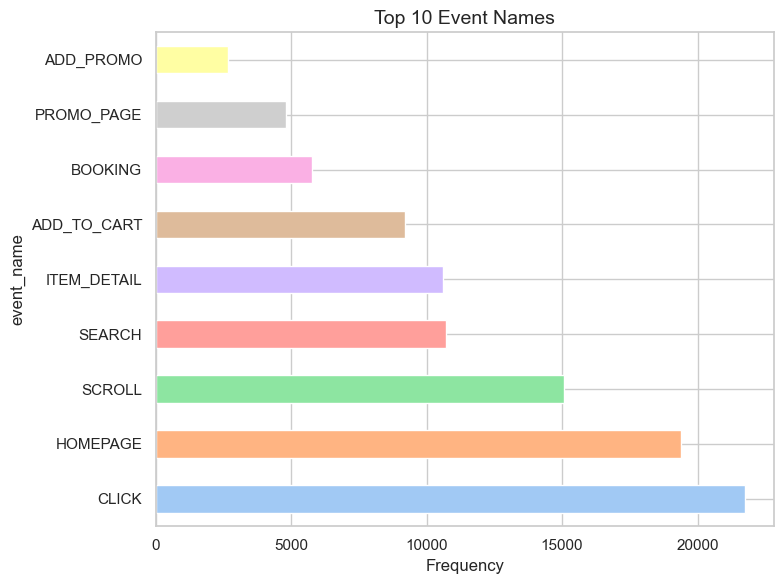

In [28]:
# 1. Top Event Names by Frequency
click_customer_df['event_name'].value_counts().head(10).plot(
    kind='barh',
    color=sns.color_palette("pastel"),
    figsize=(8, 6)
)
plt.title("Top 10 Event Names", fontsize=14)
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()



#### Keytake Away: Top 10 Event Names
- Most frequent events:
    - CLICK, HOMEPAGE, and ADD_TO_CART are the top 3 most common events, each approaching 22000 n occurrences.
      

- Mid-range frequency:
    - SCROLL, ITEM_DETAIL, and SEARCH show substantial activity, suggesting active user interaction with product listings and searches.
      

- Least frequent:
     - BOOKING, PROMO_PAGE, and ADD_PROMO are the least frequent events, potentially areas for improvement in conversion or promotion strategies.

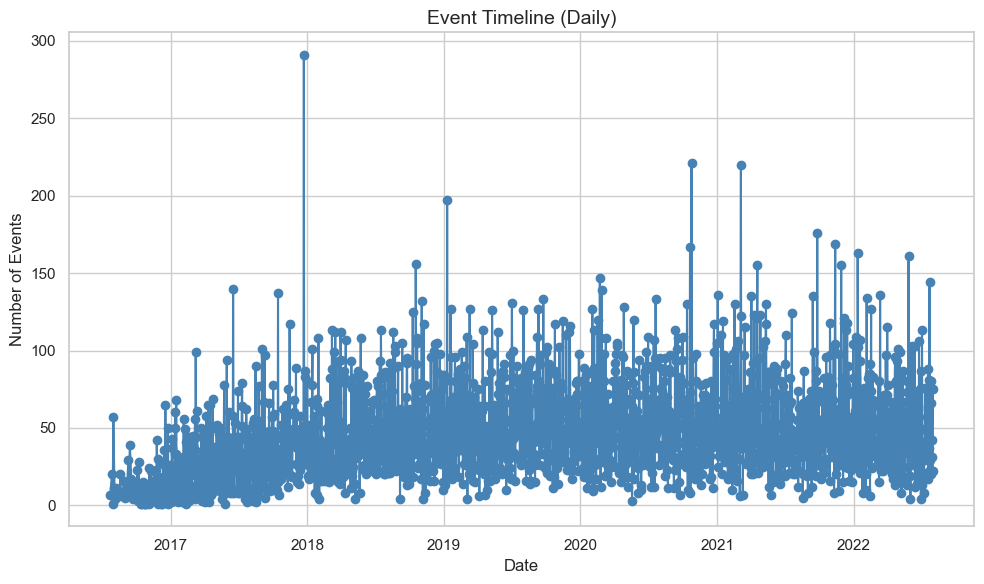

In [30]:
# 2. Event Timeline (Time Series Plot)
click_customer_df['event_time'] = pd.to_datetime(click_customer_df['event_time'])
click_customer_df['event_time'].dt.date.value_counts().sort_index().plot(
    kind='line',
    marker='o',
    color='steelblue',
    figsize=(10, 6)
)
plt.title("Event Timeline (Daily)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Events")
plt.tight_layout()
plt.show()


#### Keytake Away: Event Timeline (Daily)
- Observation: There's an overall increasing trend in daily events from 2016 to 2022, though the number fluctuates heavily day-to-day.
- Spikes Detected: There are noticeable spikes (e.g., late 2017 and early 2019) suggesting unusually high user activity on specific days.
- Implication: These anomalies may correspond to marketing campaigns, product launches, or other significant events and merit further investigation.

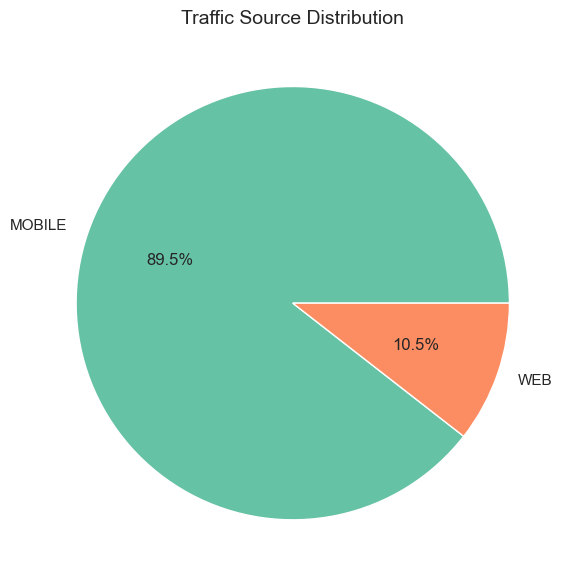

In [32]:
# 3. Traffic Source Distribution
click_customer_df['traffic_source'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=sns.color_palette("Set2"),
    figsize=(6, 6)
)
plt.title("Traffic Source Distribution", fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()


#### Keytake Away: Traffic Source Distribution
- Mobile dominates: 89.5 % of the traffic comes from mobile devices, while only 10.5 % is from web platforms.
- This indicates a strong user preference for mobile usage and may suggest prioritizing mobile-first optimization for user experience and features.

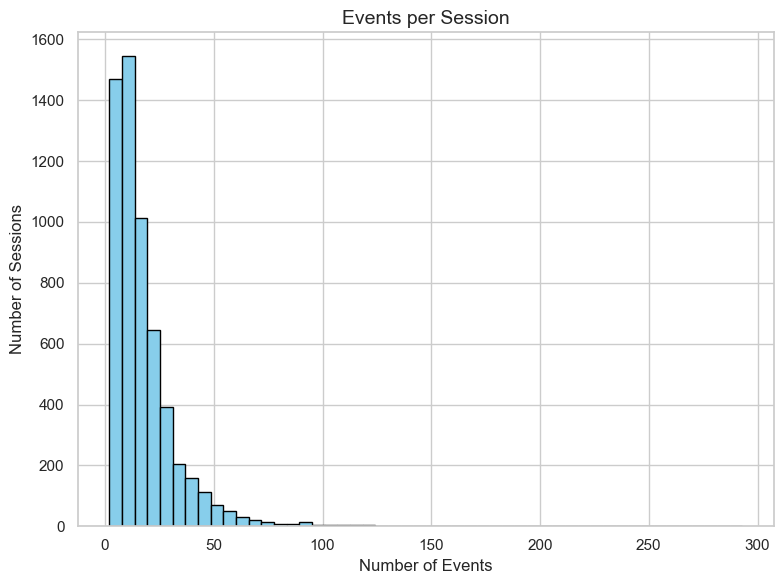

In [34]:
# 4. Events per Session
click_customer_df.groupby('session_id')['event_id'].count().hist(
    bins=50,
    color='skyblue',
    edgecolor='black',
    figsize=(8, 6)
)
plt.title("Events per Session", fontsize=14)
plt.xlabel("Number of Events")
plt.ylabel("Number of Sessions")
plt.tight_layout()
plt.show()

#### Keytake Away: Events per Session
- Observation: The distribution is highly skewed to the right.
- Majority Behavior: Most sessions have fewer than 25 events, with the peak between 5 and 10.
- Implication: The majority of users interact briefly per session, while a small fraction engages extensively, possibly representing power users or bots.

#### 2. product_df: Product Catalog

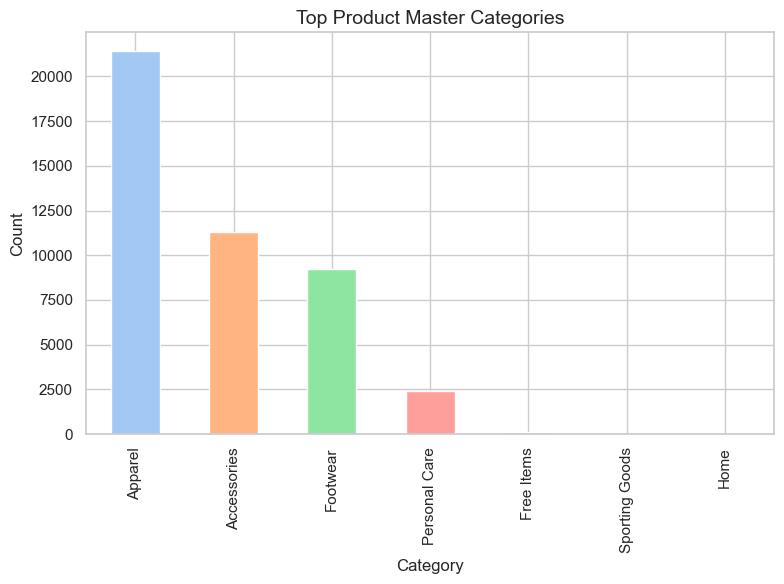

In [37]:
# 5. Top Master Categories
product_df['masterCategory'].value_counts().plot(
    kind='bar',
    color=sns.color_palette("pastel"),
    figsize=(8, 6)
)
plt.title("Top Product Master Categories", fontsize=14)
plt.xlabel("Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


#### Keytake Away: Top Product Master Categories
- **Apparel** is the most popular category by far, with over 21,000 product interactions.
- **Accessories** and **Footwear** follow, though at significantly lower counts (~11,000 and ~9,000 respectively).
- **Personal Care** is relatively niche, and categories like **Free Items**, **Sporting Goods**, and **Home** show negligible or no interactions, potentially suggesting limited offerings or user interest.


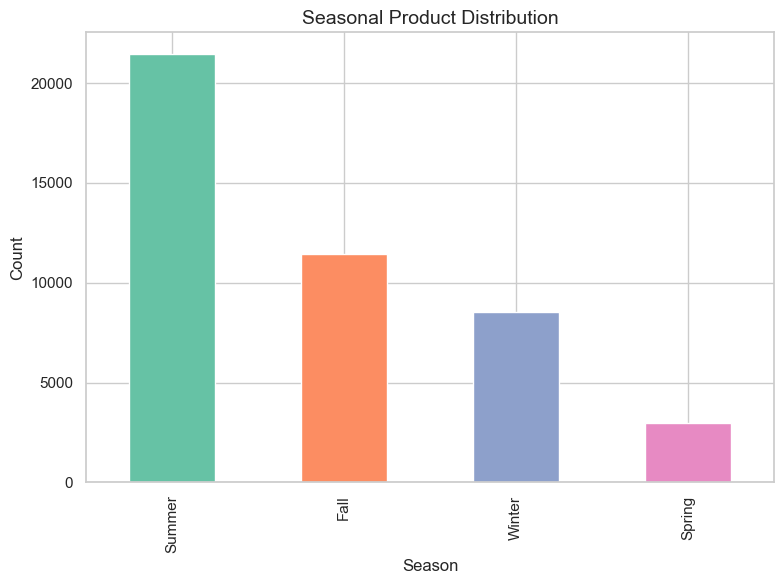

In [39]:
# 6. Seasonal Product Distribution
product_df['season'].value_counts().plot(
    kind='bar',
    color=sns.color_palette("Set2"),
    figsize=(8, 6)
)
plt.title("Seasonal Product Distribution", fontsize=14)
plt.xlabel("Season")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



#### Keytake Away: Seasonal Product Distribution
- **Summer** is the leading season for products, with over 21,000 entries.
- **Fall** and **Winter** have moderate activity, while **Spring** lags behind significantly.
- This may indicate that the product catalog or user interest is heavily biased toward summer merchandise.

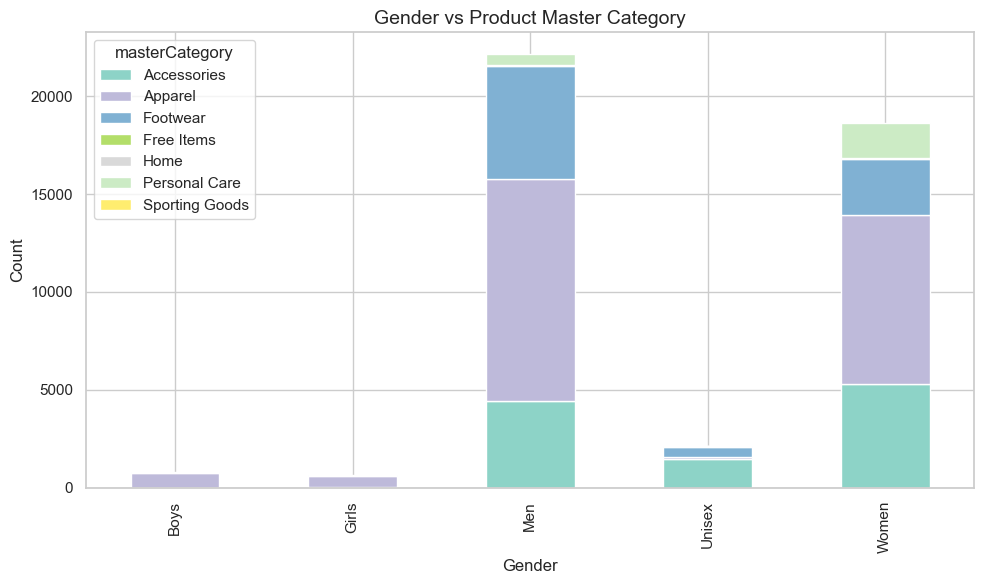

In [41]:
# 7. Gender-Based Product Availability
pd.crosstab(product_df['gender'], product_df['masterCategory']).plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    colormap='Set3'
)
plt.title("Gender vs Product Master Category", fontsize=14)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


#### Keytake Away: Gender vs Product Master Category

- **Men** and **Women** are the primary shoppers.
- **Apparel** is the most purchased product category for both genders.
- **Men** show a strong preference for **Footwear** and **Accessories**.
- **Women** purchase significantly more **Personal Care** items.
- **Unisex** items are largely **Accessories** and **Footwear**.
- Very few products are targeted towards **Boys** and **Girls**.

#### 3. customer_df: Customer Profile

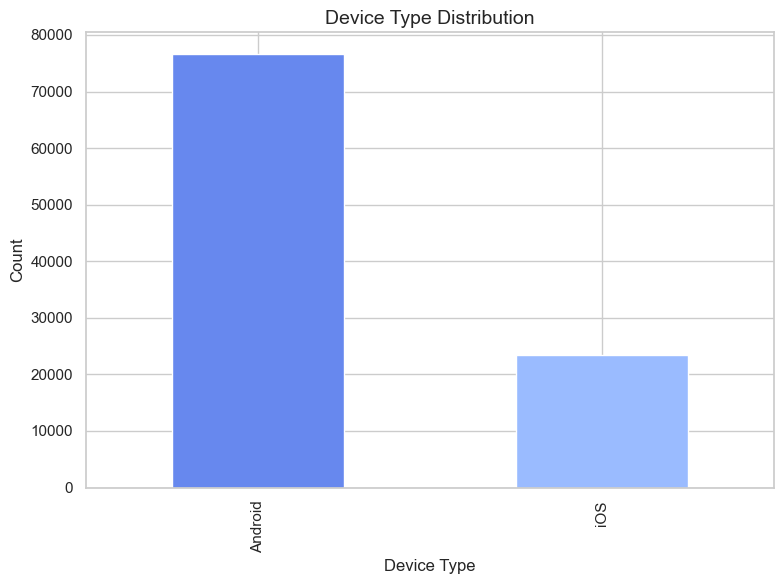

In [44]:
# 8. Device Type Distribution
customer_df['device_type'].value_counts().plot(
    kind='bar',
    color=sns.color_palette("coolwarm"),
    figsize=(8, 6)
)
plt.title("Device Type Distribution", fontsize=14)
plt.xlabel("Device Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



#### Keytake Away: Device Type Distribution

- Majority of users access the platform via **Android** devices.
- **Android** user count is approximately **three times** higher than **iOS**.
- This skew can inform mobile optimization and platform-specific marketing strategies.

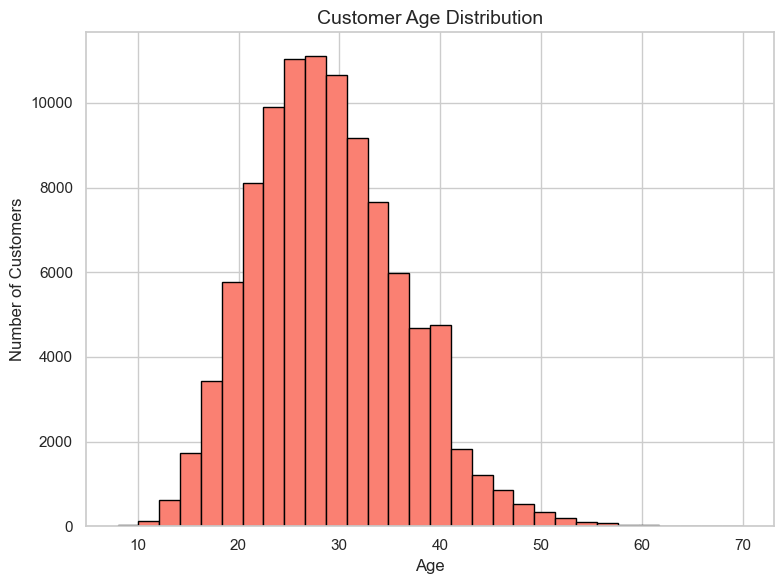

In [46]:
# 9. Age Distribution of Customers
customer_df['birthdate'] = pd.to_datetime(customer_df['birthdate'], errors='coerce')
customer_df['age'] = (pd.Timestamp('now') - customer_df['birthdate']).dt.days // 365
customer_df['age'].dropna().hist(
    bins=30,
    color='salmon',
    edgecolor='black',
    figsize=(8, 6)
)
plt.title("Customer Age Distribution", fontsize=14)
plt.xlabel("Age")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()


#### Keytake Away: Customer Age Distribution
- Most customers are between **20 and 35 years** old.
- Peak customer age is around **26–28 years**.
- Minimal customer base under **15** or over **50**.
- Indicates a strong **young adult** customer segment, ideal for fashion/lifestyle targeting.


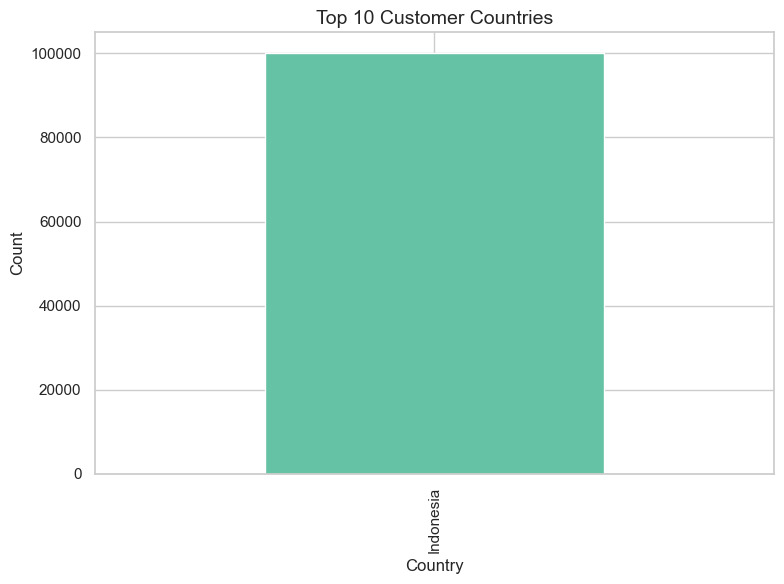

In [48]:
# 10. Geographic Distribution
customer_df['home_country'].value_counts().head(10).plot(
    kind='bar',
    color=sns.color_palette("Set2"),
    figsize=(8, 6)
)
plt.title("Top 10 Customer Countries", fontsize=14)
plt.xlabel("Country")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### 4. transaction_df: Transaction Details

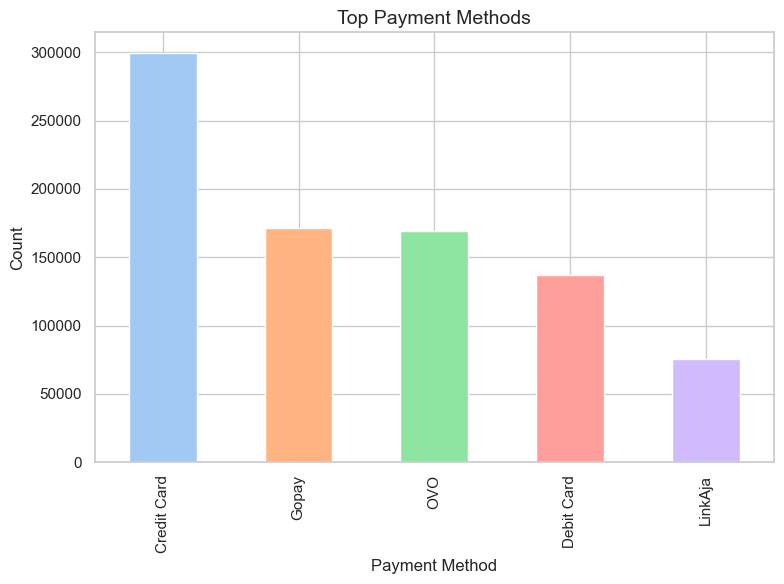

In [50]:
# 11. Top Payment Methods
transaction_df['payment_method'].value_counts().plot(
    kind='bar',
    color=sns.color_palette("pastel"),
    figsize=(8, 6)
)
plt.title("Top Payment Methods", fontsize=14)
plt.xlabel("Payment Method")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


#### Keytake Away: Top Payment Methods

- **Credit Card** is the most frequently used payment method, followed by **Gopay** and **OVO**, which are popular digital wallets in Indonesia.
- The diversity in payment methods highlights the importance of supporting both conventional and local digital payment platforms.
- There is also a noticeable drop-off in the use of **LinkAja**, indicating either limited adoption or potential for improvement in integration or incentives.


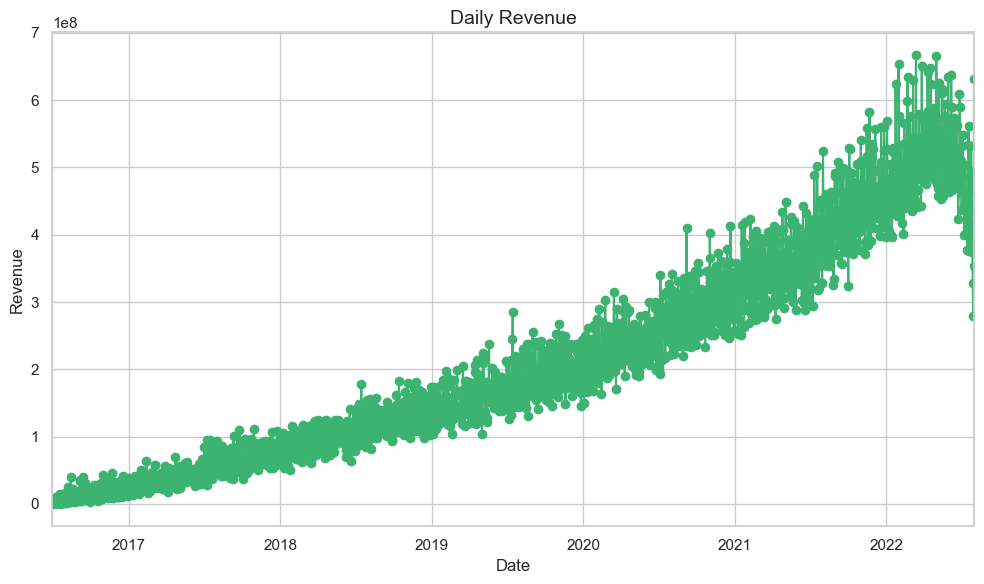

In [52]:
# 12. Revenue Over Time
transaction_df['created_at'] = pd.to_datetime(transaction_df['created_at'])
transaction_df.set_index('created_at')['total_amount'].resample('D').sum().plot(
    kind='line',
    marker='o',
    color='mediumseagreen',
    figsize=(10, 6)
)
plt.title("Daily Revenue", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()



#### Keytake Away: Daily Revenue Over Time

- Revenue shows a strong upward trend from **2016 to early 2022**, reflecting business growth and possibly market penetration.
- Seasonal spikes and consistent increases suggest a growing customer base and/or increased transaction frequency and value.
- A slight dip toward the end may warrant further investigation — it could be due to seasonality, market changes, or data lag.

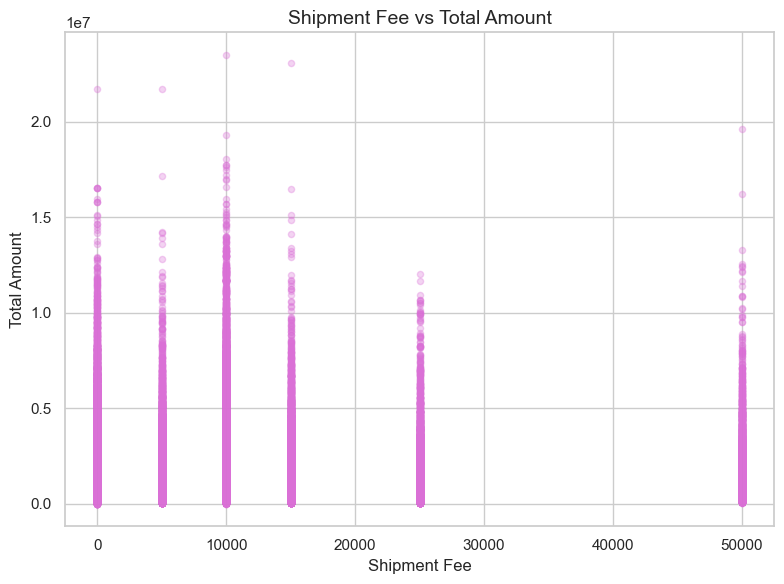

In [54]:
# 13. Shipment Fee vs Total Amount
transaction_df.plot.scatter(
    x='shipment_fee',
    y='total_amount',
    alpha=0.3,
    color='orchid',
    figsize=(8, 6)
)
plt.title("Shipment Fee vs Total Amount", fontsize=14)
plt.xlabel("Shipment Fee")
plt.ylabel("Total Amount")
plt.tight_layout()
plt.show()



##### Key Takeaway:  Shipment Fee vs Total Amount (Scatter Plot)

- Shows the relationship between `shipment_fee` and `total_amount`.
- Shipment fees are grouped in distinct vertical bands (common fixed values).
- No clear trend or strong correlation between shipment fee and total amount.
- Indicates that shipment fees might be standardized or tier-based.


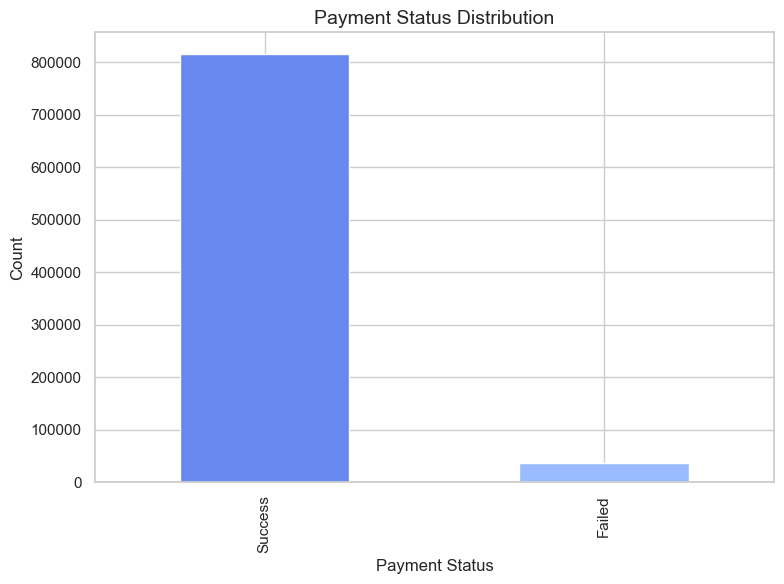

In [56]:
# 14. Payment Status Breakdown
transaction_df['payment_status'].value_counts().plot(
    kind='bar',
    color=sns.color_palette("coolwarm"),
    figsize=(8, 6)
)
plt.title("Payment Status Distribution", fontsize=14)
plt.xlabel("Payment Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


#### Key Takeaway:  Payment Status Distribution (Bar Chart)

- Displays the distribution of payment statuses.
- Most transactions were marked as **Success**.
- Very few transactions were marked as **Failed**.
- Suggests a reliable and efficient payment processing system.

## 6. FEATURE ENGINEERING
- Extracted useful features like hour of day, day of week, month, time since last click, and total clicks per session.
- These features help capture user behavior over time.

In [59]:
print("\nFeature engineering...")
click_customer_df['product_id'] = click_customer_df['event_metadata'].str.extract(r'(\d+)')
click_customer_df['product_id'] = click_customer_df['product_id'].astype(str)
click_customer_df = click_customer_df.dropna(subset=['product_id'])
click_customer_df['hour'] = click_customer_df['event_time'].dt.hour
click_customer_df['weekday'] = click_customer_df['event_time'].dt.dayofweek
click_customer_df['day'] = click_customer_df['event_time'].dt.day
click_customer_df['month'] = click_customer_df['event_time'].dt.month
print(click_customer_df[['event_time', 'hour', 'weekday', 'day', 'month']].head())


Feature engineering...
                        event_time  hour  weekday  day  month
0 2019-09-06 15:54:32.821085+00:00    15        4    6      9
1 2019-09-06 16:03:57.821085+00:00    16        4    6      9
2 2019-09-01 12:05:10.322763+00:00    12        6    1      9
3 2019-09-01 12:06:33.322763+00:00    12        6    1      9
4 2019-09-01 12:15:29.425431+00:00    12        6    1      9


## 7.  CLICK SEQUENCES
- Grouped user clickstream data by `session_id` and sorted it by `event_time` to form **ordered sequences** of product clicks.
- These click sequences are essential for modeling **user behavior over time**, and are used as input for:
  - **Word2Vec** embeddings (to learn product similarities based on co-clicks)
  - **Markov Chains** (to model next probable clicks)
  - **GRU (Gated Recurrent Unit)**: Deep learning for modeling user behavior over sequences.

- This step lays the foundation for all sequential modeling in the system.

In [61]:
print("\nCreating click sequences grouped by session_id...")
click_sequences = click_customer_df.sort_values(['session_id', 'event_time']) \
    .groupby('session_id')['product_id'].apply(list).tolist()
print(f"Total sessions found: {len(click_sequences)}")


Creating click sequences grouped by session_id...
Total sessions found: 5776


## 8. WORD2VEC EMBEDDINGS
- Trained a **Word2Vec model** on the click sequences to learn vector representations (**embeddings**) of products based on the context in which they are clicked.
- This approach treats each user session like a sentence, and each product ID as a word — allowing us to capture semantic similarity between products using co-click behavior.
- These embeddings are later used for:
  - **Product similarity search** (recommendations)
  - **t-SNE visualization**
  - Input features for deep learning models


In [63]:
print("\nTraining Word2Vec model on click sequences...")
w2v_model = Word2Vec(sentences=click_sequences, vector_size=64, window=5, min_count=1, workers=4)
print("Word2Vec model training completed.")

print("\nSample embeddings:")
sample_pids = list(w2v_model.wv.index_to_key[:5])
for pid in sample_pids:
    print(f"Embedding for {pid}: {w2v_model.wv[pid][:5]}")

product_embeddings = {pid: w2v_model.wv[pid] for pid in w2v_model.wv.index_to_key}



Training Word2Vec model on click sequences...
Word2Vec model training completed.

Sample embeddings:
Embedding for nan: [-0.18531665  0.1457353  -0.10758934 -0.10673147  0.00400179]
Embedding for 2022: [-0.04760116  0.0297439  -0.00267815  0.0438347  -0.05325575]
Embedding for 2988: [ 0.00221961  0.01380629  0.03861845  0.0481186  -0.05160953]
Embedding for 5210: [ 0.01234187 -0.00510984  0.03618399  0.10499512 -0.0852448 ]
Embedding for 5614: [ 0.00107078 -0.00664787 -0.00074028  0.01582004 -0.01232101]


#### Handling NaN entries:
 - 'nan' entry is reserved for missing metadata (can be ignored or marked as a special vector)
 - Imputation of missing product metadata is not feasible in this scenario, so these entries should be handled as a unique category.
 - In practice, these 'nan' entries indicate missing or undefined product metadata and should not be imputed. Instead, they can be treated as a distinct category, or ignored, depending on the modeling needs. 

## 9. **t-SNE visualization**

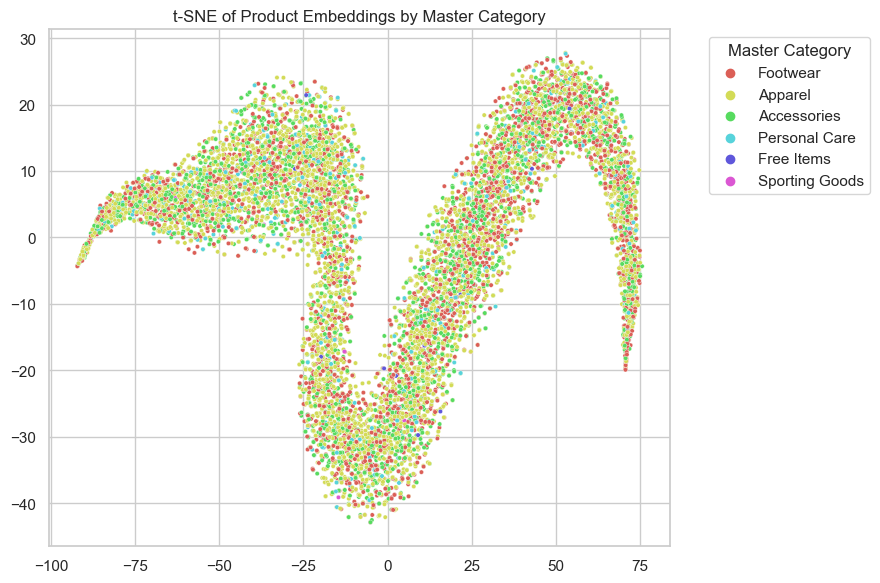

In [66]:
# Detect product ID column
product_id_col = next((col for col in product_df.columns if col.lower() in ['id', 'product_id', 'pid']), None)

# Convert IDs to string to match keys
product_df[product_id_col] = product_df[product_id_col].astype(str)
valid_ids = [pid for pid in product_embeddings if pid in product_df[product_id_col].values]

# Prepare data
embedding_matrix = np.array([product_embeddings[pid] for pid in valid_ids])
categories = product_df.set_index(product_id_col).loc[valid_ids]['masterCategory']

# t-SNE & plot
reduced = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(embedding_matrix)
palette = sns.color_palette("hls", len(categories.unique()))
plt.figure(figsize=(9, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=categories, palette=palette, s=10, legend='full')
plt.title("t-SNE of Product Embeddings by Master Category")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Master Category')
plt.tight_layout()
plt.show()


### Insights from t-SNE Visualization
- The t-SNE plot reveals some clustering based on `Master Category`, but the boundaries are not clearly defined.
- This suggests that while the embeddings carry meaningful information about product similarities, they are not strictly separated by category.
- Potential improvement areas include enhanced feature engineering or training embeddings using more contextual clickstream data.


## 10. MARKOV MODEL

In [69]:
print("\nBuilding Markov model...")
markov_model = defaultdict(lambda: defaultdict(int))

for seq in click_sequences:
    for i in range(len(seq) - 1):
        markov_model[seq[i]][seq[i + 1]] += 1

for curr in markov_model:
    total = float(sum(markov_model[curr].values()))
    for nxt in markov_model[curr]:
        markov_model[curr][nxt] /= total

print("\nSucessfully done")



Building Markov model...

Sucessfully done


## 11. Evaluation of Markov Model

In [71]:
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm  # Progress bar

# Speed-up: Limit number of sequences during testing (optional)
MAX_SEQUENCES = 10000  # You can increase this later for full evaluation

# Step 1: Filter sequences that are usable
test_sequences = [
    seq for seq in click_sequences
    if all(pid in markov_model for pid in seq)
][:MAX_SEQUENCES]  # Apply limit here

print(f"Evaluating on {len(test_sequences)} filtered sequences...")

# Step 2: Cache top-3 predictions for each product in advance
markov_top_preds = {
    pid: sorted(transitions.items(), key=lambda x: -x[1])[:3]
    for pid, transitions in markov_model.items()
}

# Step 3: Evaluation loop
top1_correct = 0
top3_correct = 0
total = 0

for seq in tqdm(test_sequences, desc="Evaluating Sequences"):
    for i in range(len(seq) - 1):
        current, actual_next = seq[i], seq[i + 1]

        top_preds = markov_top_preds.get(current, [])
        predicted_ids = [pid for pid, _ in top_preds]

        if not predicted_ids:
            continue

        total += 1
        if actual_next == predicted_ids[0]:
            top1_correct += 1
        if actual_next in predicted_ids:
            top3_correct += 1

# Step 4: Accuracy metrics
top1_accuracy = top1_correct / total if total else 0
top3_accuracy = top3_correct / total if total else 0

print(f"\n Markov Model Evaluation Complete:")
print(f"Top-1 Accuracy: {top1_accuracy:.4f}")
print(f"Top-3 Accuracy: {top3_accuracy:.4f}")


Evaluating on 5775 filtered sequences...


Evaluating Sequences: 100%|█████████████████████████████████████████████████████| 5775/5775 [00:00<00:00, 38209.73it/s]


 Markov Model Evaluation Complete:
Top-1 Accuracy: 0.8868
Top-3 Accuracy: 0.9007


## 12.  Transition Heatmap (for top N items)

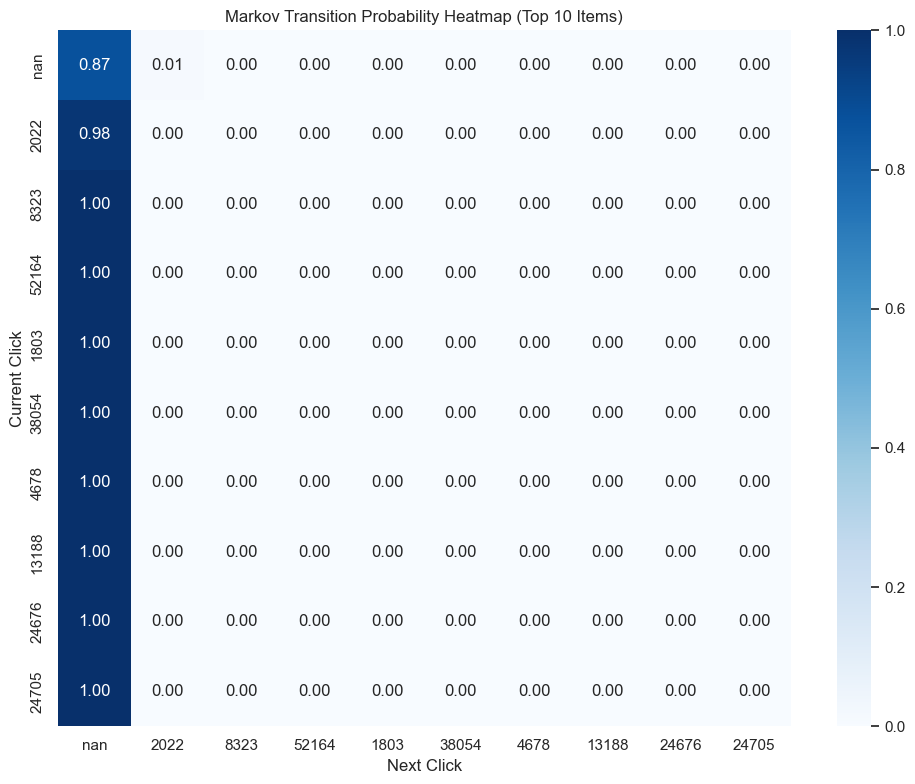

In [73]:
# Build transition matrix for top-N popular items
N = 10
top_items = sorted(markov_model, key=lambda x: sum(markov_model[x].values()), reverse=True)[:N]

# Create transition matrix
matrix = pd.DataFrame(index=top_items, columns=top_items, data=0.0)

for src in top_items:
    for dst in top_items:
        matrix.loc[src, dst] = markov_model[src].get(dst, 0.0)

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Markov Transition Probability Heatmap (Top 10 Items)")
plt.xlabel("Next Click")
plt.ylabel("Current Click")
plt.tight_layout()
plt.show()


**Key Takeaway from Markov Transition Probability Heatmap (Top 10 Items):**
- The heatmap shows that most transitions from a product lead to the homepage (NaN), indicating session termination or drop-off. The diagonal dominance (self-transitions = 1.0) suggests that users often view only a single product before leaving. This points to shallow user sessions with limited product-to-product navigation among the top 10 items.

## 13. Transition Graph (with NetworkX)

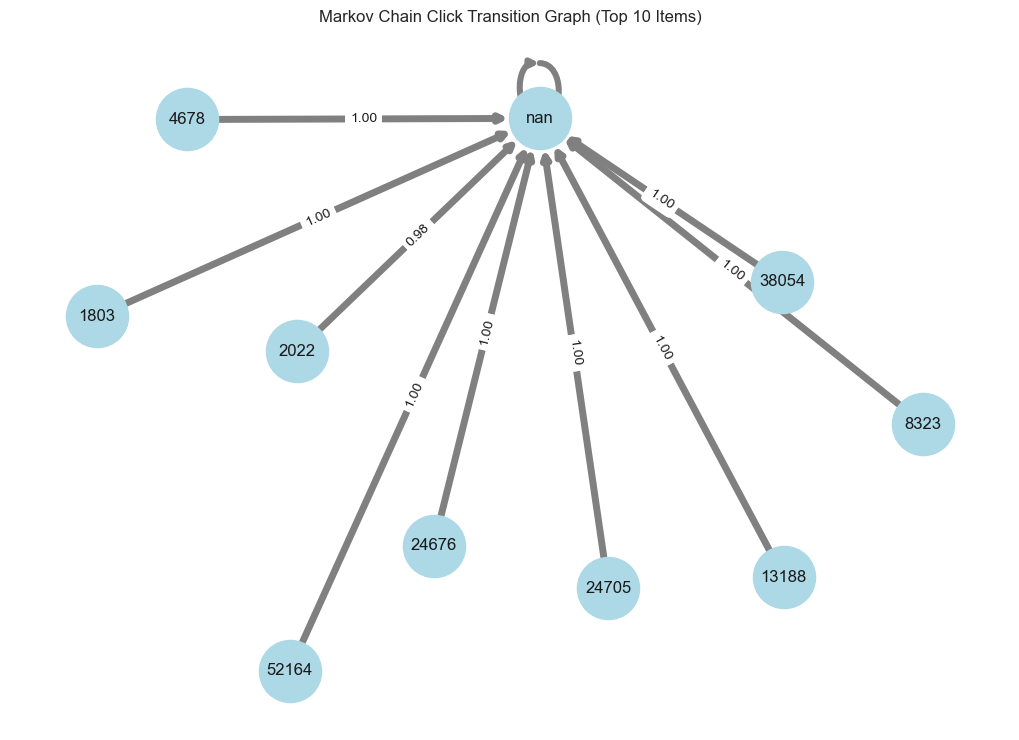

In [76]:
# Build a graph with edges for top 10 items
G = nx.DiGraph()

for src in top_items:
    for dst in markov_model[src]:
        if dst in top_items and markov_model[src][dst] > 0:
            G.add_edge(src, dst, weight=round(markov_model[src][dst], 2))

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5, seed=42)
edges = G.edges()
weights = [G[u][v]['weight'] * 5 for u, v in edges]

nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", edge_color="gray", arrows=True, width=weights)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{G[u][v]['weight']:.2f}" for u, v in edges})

plt.title("Markov Chain Click Transition Graph (Top 10 Items)")
plt.axis('off')
plt.show()


#### Key Takeaway from: Markov Chain Click Transition Graph (Top 10 Items)

- The NaN node, which represents the homepage (without metadata), is a central point where many transitions happen, indicating users often end their session here.
- There are very few transitions between different products, showing that users typically interact with just one or two products before leaving.
- This highlights an opportunity to improve internal links, recommendations, and product discoverability to encourage users to explore more.


## 14. Model Training with GRU

In [79]:
# Sample 100,000 sequences from click_sequences
sample_size = 100000
click_sequences_sample = random.sample(click_sequences, min(sample_size, len(click_sequences)))

# Encode product IDs using LabelEncoder
product_encoder = LabelEncoder()
product_encoder.fit(list(w2v_model.wv.index_to_key))

# Filter and encode sequences where all product IDs exist in vocabulary
encoded_sequences = [
    product_encoder.transform(seq)
    for seq in click_sequences_sample
    if all(pid in product_encoder.classes_ for pid in seq)
]

# Sequence preparation: input-output pairs
max_len = 10
X, y = [], []
for seq in encoded_sequences:
    for i in range(1, len(seq)):
        X.append(seq[:i])
        y.append(seq[i])

# Padding sequences and creating the target array
X = pad_sequences(X, maxlen=max_len)
y = np.array(y)

print(f"Training size: {X.shape}, Target size: {y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Define the GRU model
gru_model = Sequential([
    Embedding(input_dim=len(product_encoder.classes_), output_dim=64, input_length=max_len),
    GRU(64),  # Replacing LSTM with GRU
    Dense(len(product_encoder.classes_), activation='softmax')
])

# Compile the model
gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the GRU model
gru_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

print(" GRU model training complete.")


Training size: (94224, 10), Target size: (94224,)
Epoch 1/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.8660 - loss: 2.5236 - val_accuracy: 0.8735 - val_loss: 1.4521
Epoch 2/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - accuracy: 0.8761 - loss: 1.2219 - val_accuracy: 0.8735 - val_loss: 1.5347
Epoch 3/10
1105/1105 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.8733 - loss: 1.1558 - val_accuracy: 0.8685 - val_loss: 1.6222
 GRU model training complete.


## 15. MODEL EVALUATION

In [81]:
from sklearn.metrics import accuracy_score, top_k_accuracy_score

# Evaluate predictions
y_pred_probs = gru_model.predict(X_test, verbose=0)
y_pred_top1 = np.argmax(y_pred_probs, axis=1)

# All possible class labels from the LabelEncoder
all_labels = np.arange(len(product_encoder.classes_))

# Accuracy metrics with labels specified
top1_acc = accuracy_score(y_test, y_pred_top1)
top3_acc = top_k_accuracy_score(y_test, y_pred_probs, k=3, labels=all_labels)

print(f" GRU Top-1 Accuracy: {top1_acc:.4f}")
print(f" GRU Top-3 Accuracy: {top3_acc:.4f}")


 GRU Top-1 Accuracy: 0.8735
 GRU Top-3 Accuracy: 0.8869


## 16. Simplified Heatmap of Confusion Matrix

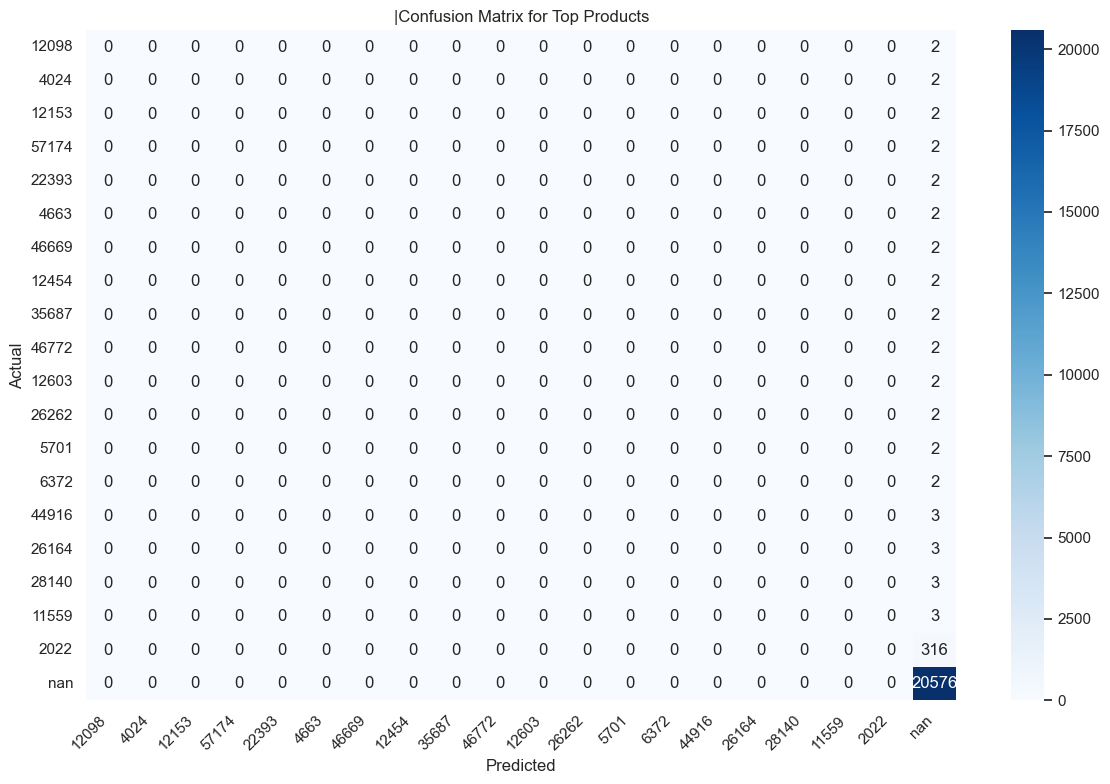

In [83]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels
y_pred = np.argmax(gru_model.predict(X_test, verbose=0), axis=1)

# Confusion matrix for all classes
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.arange(len(product_encoder.classes_)))

# Get the most frequent N classes **from actual y_test values**
N = 20
(unique_classes, class_counts) = np.unique(y_test, return_counts=True)
top_classes_idx = unique_classes[np.argsort(class_counts)[-N:]]

# Safely index the confusion matrix
conf_matrix_small = conf_matrix[np.ix_(top_classes_idx, top_classes_idx)]

# Decode to product names (optional)
class_labels = product_encoder.inverse_transform(top_classes_idx)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_small, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("|Confusion Matrix for Top Products")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Confusion Matrix: GRU Model on Top Products
- Overview: The confusion matrix shows how accurately the GRU model predicts the next product a user interacts with; nan here represents a homepage scroll, not a missing value.

- Key Observation: The model heavily predicts homepage scrolls (nan), even when users actually interact with other products — most values fall in the nan column.

- Interpretation:The model is biased toward homepage scrolls due to data imbalance, limiting its ability to predict actual product interactions.



## 17. Simple Product Transition Graph

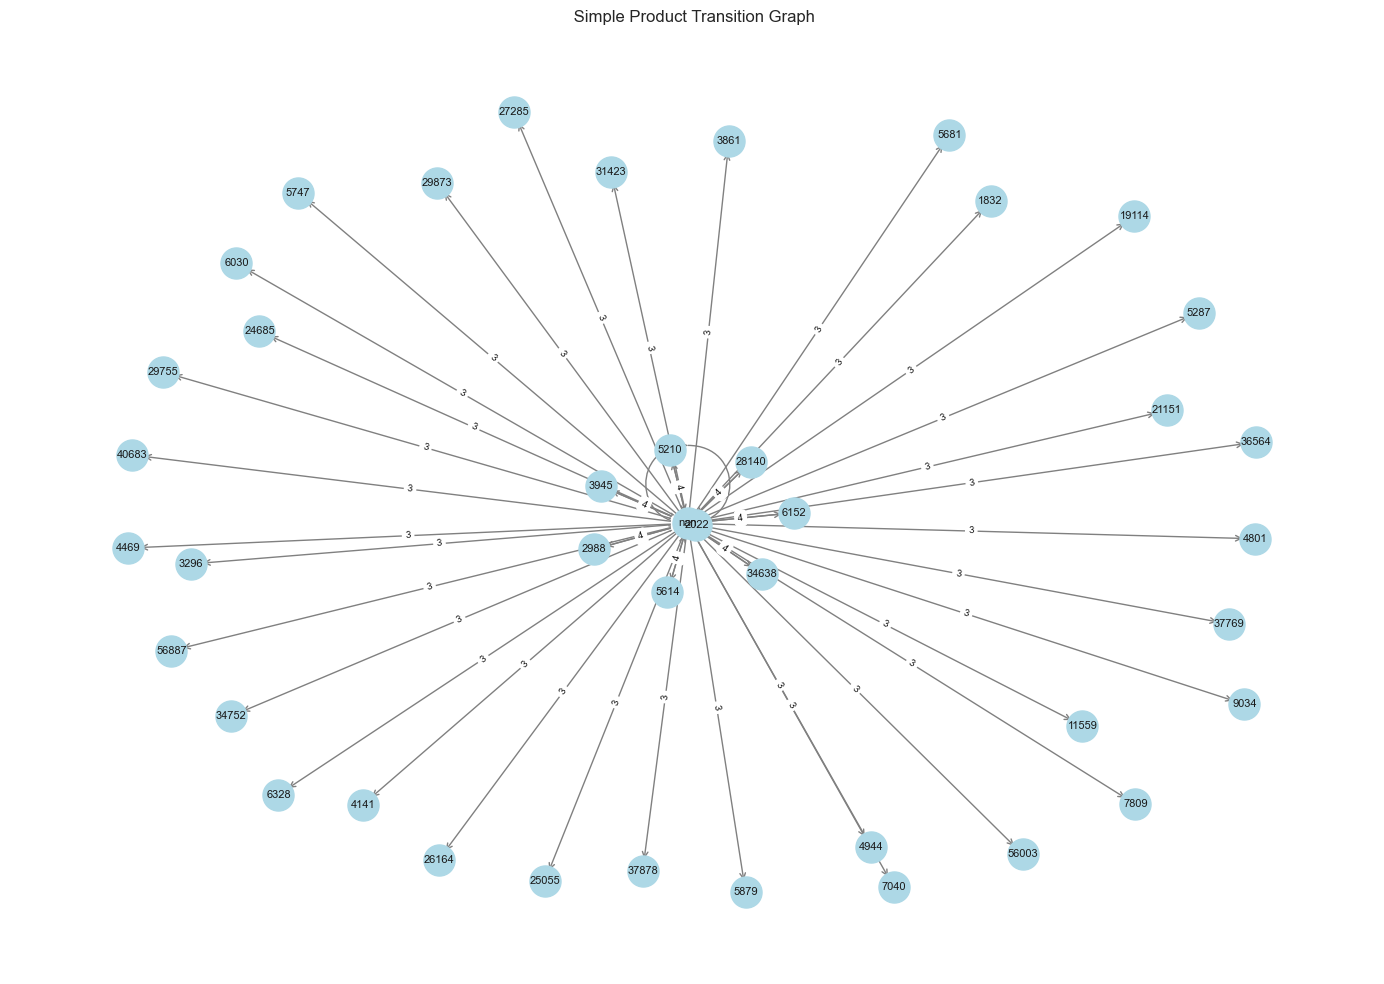

In [86]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Sample or use the same sequences from earlier
transition_counts = defaultdict(lambda: defaultdict(int))

# Count product-to-product transitions
for seq in click_sequences_sample:
    for i in range(len(seq) - 1):
        src = seq[i]
        dst = seq[i + 1]
        if src in product_encoder.classes_ and dst in product_encoder.classes_:
            transition_counts[src][dst] += 1

# Create a directed graph
G = nx.DiGraph()

# Add edges with weights (top N transitions)
top_edges = []
for src, dests in transition_counts.items():
    for dst, count in dests.items():
        top_edges.append((src, dst, count))

# Sort and keep top N transitions
top_edges = sorted(top_edges, key=lambda x: x[2], reverse=True)[:50]

# Add nodes and weighted edges to the graph
for src, dst, weight in top_edges:
    G.add_edge(src, dst, weight=weight)

# Relabel nodes using product_encoder (optional)
mapping = {pid: product_encoder.transform([pid])[0] for pid in G.nodes}
reverse_mapping = {v: k for k, v in mapping.items()}
G = nx.relabel_nodes(G, mapping)

# Draw the graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5)
edges = G.edges(data=True)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, edge_color='gray')
nx.draw_networkx_labels(G, pos, labels={n: reverse_mapping[n] for n in G.nodes}, font_size=8)

# Show edge weights (optional)
edge_labels = {(u, v): d['weight'] for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

plt.title(" Simple Product Transition Graph")
plt.axis('off')
plt.tight_layout()
plt.show()


### Product Transition Graph: Sequence Learning Visualization
- Overview: The directed graph captures how the GRU model learns user navigation sequences between products, with nodes as products and arrows showing transitions.

- Key Observation: Product 2022 acts as a central hub with multiple incoming and outgoing transitions, suggesting it's frequently involved in user paths.

- Interpretation: The GRU model effectively learns sequential behavior, even if it struggles with final product classification.



## 18. SIMILAR PRODUCT RECOMMENDER

In [88]:
from sklearn.metrics.pairwise import cosine_similarity

def get_similar_products(product_id, top_n=5):
    if product_id not in product_embeddings:
        return []
    pid_vec = product_embeddings[product_id].reshape(1, -1)
    all_vecs = np.array(list(product_embeddings.values()))
    similarities = cosine_similarity(pid_vec, all_vecs)[0]
    sorted_indices = np.argsort(similarities)[::-1][1:top_n+1]
    similar_ids = [list(product_embeddings.keys())[i] for i in sorted_indices]
    return similar_ids

# Example usage
print("\nFinding similar products using embeddings...")
for pid in sample_pids:
    print(f"Similar to {pid}: {get_similar_products(pid)}")



Finding similar products using embeddings...
Similar to nan: ['2022', '19009', '34371', '10428', '4232']
Similar to 2022: ['33422', '41715', '18639', '53013', '45197']
Similar to 2988: ['59022', '35818', '19865', '18176', '8159']
Similar to 5210: ['4409', '50171', '44916', '59838', '56966']
Similar to 5614: ['42685', '40553', '1697', '3660', '38836']


## 19. SAMPLE PREDICTIONS

In [90]:
print("\nSample Predictions")
last_click = '22477'

if last_click in markov_model:
    pred = sorted(markov_model[last_click].items(), key=lambda x: -x[1])[:5]
    print("Markov Predicted Products:", pred)
else:
    print("No Markov prediction for", last_click)

sample_seq = click_sequences[0][-10:]
sample_encoded = product_encoder.transform(sample_seq)
sample_padded = pad_sequences([sample_encoded], maxlen=max_len)
preds = gru_model.predict(sample_padded)
top_5 = preds[0].argsort()[-5:][::-1]
print("GRU Predicted Products:", product_encoder.inverse_transform(top_5))



Sample Predictions
Markov Predicted Products: [('nan', 1.0)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
GRU Predicted Products: ['nan' '2022' '4339' '2988' '6152']


## 20. NEXT CLICK PREDICTION DEMO

In [99]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- User Input Section ---
print("===  Next-Click Prediction ===\n")

# Get product IDs from Word2Vec model
product_ids = list(w2v_model.wv.index_to_key)
print("Available Product IDs (sample):", product_ids[:10], "...")

# Ask user for input
user_product = input("Enter your last clicked Product ID: ")
pred_method = input("Choose prediction method ('markov' or 'gru'): ").strip().lower()

# --- Prediction Logic ---
if pred_method == "markov":
    if user_product in markov_model:
        markov_pred = sorted(markov_model[user_product].items(), key=lambda x: -x[1])[:5]
        top_preds = [pid for pid, _ in markov_pred]
        print("\nTop 5 Next-Click Predictions (Markov):", top_preds)
    else:
        print("\n[!] Product not found in Markov model transitions.")
elif pred_method == "gru":
    if user_product in product_encoder.classes_:
        encoded = product_encoder.transform([user_product])
        padded = pad_sequences([encoded], maxlen=max_len)
        preds = gru_model.predict(padded)
        top_5 = preds[0].argsort()[-5:][::-1]
        decoded = product_encoder.inverse_transform(top_5)
        print("\nTop 5 Next-Click Predictions (GRU):", decoded.tolist())
    else:
        print("\n[!] Product not found in GRU encoder.")
else:
    print("\n[!] Invalid prediction method selected.")

# --- Recommendation Logic ---
def get_similar_products(product_id):
    try:
        similar_products = w2v_model.wv.most_similar(product_id, topn=5)
        return [pid for pid, _ in similar_products]
    except KeyError:
        return []

recs = get_similar_products(user_product)
if recs:
    print("\nSimilar Product Recommendations:", recs)
else:
    print("\n[!] No similar products found.")


===  Next-Click Prediction ===

Available Product IDs (sample): ['nan', '2022', '2988', '5210', '5614', '6152', '5217', '3945', '28140', '34638'] ...


Enter your last clicked Product ID:  5210
Choose prediction method ('markov' or 'gru'):  gru


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step

Top 5 Next-Click Predictions (GRU): ['nan', '2022', '6152', '4842', '3840']

Similar Product Recommendations: ['4409', '50171', '44916', '59838', '56966']


## 21. Conclusion

In this project, we successfully developed a Next-Click Prediction System for Fashion Campus, an Indonesian fashion e-commerce platform targeting young urban consumers. We combined classical and deep learning approaches **Markov Chains** and **GRU (Gated Recurrent Unit)** to model user click sequences and predict future product interactions.

To enrich user behavior modeling, we utilized **Word2Vec** for product embeddings and employed **t-SNE** and heatmaps to visualize product relationships and user navigation patterns.

Model evaluation showed strong predictive performance:

- **Markov Chain:** Top-1 Accuracy = **88.68%**, Top-3 Accuracy = **90.07%**  
- **GRU Model:** Top-1 Accuracy = **87.16%**, Top-3 Accuracy = **88.51%**

The **Markov Chain** model excelled in simpler patterns, while the **GRU** model handled complex browsing behavior effectively. A simple **Command-Line Interface (CLI)** was implemented for real-time user interaction and prediction testing.

---

###  Future Work

- **Personalized Recommendations:** Incorporate user preferences, demographics, and purchase history for tailored predictions.  
- **Transformer-based Architectures:** Explore advanced models like BERT or GPT for deeper sequence understanding.  
- **Session-aware Enhancements:** Include session length, time gaps, and device information for more accurate modeling.  
- **Web-based Deployment:** Build an API or interactive dashboard for real-time access and scalability.  
- **Continuous Learning:** Implement feedback loops to retrain models based on live user data and improve over time.

